<a href="https://colab.research.google.com/github/sean-halpin/diffusion_models/blob/main/min_diffusion_dct_guided.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf /content/images/*

In [ ]:
!mkdir -p /content/images/

In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid

## CIFAR

### UNet

In [ ]:
"""
Simple Unet Structure.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F


class Conv3(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
        )

        self.is_res = is_res

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.main(x)
        if self.is_res:
            x = x + self.conv(x)
            return x / 1.414
        else:
            return self.conv(x)


class UnetDown(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(UnetDown, self).__init__()
        layers =  [
                    Conv3(in_channels, out_channels), nn.MaxPool2d(2)
                  ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            Conv3(out_channels, out_channels),
            Conv3(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = torch.cat((x, skip), 1)
        x = self.model(x)

        return x


class TimeSiren(nn.Module):
    def __init__(self, emb_dim: int) -> None:
        super(TimeSiren, self).__init__()

        self.lin1 = nn.Linear(1, emb_dim, bias=False)
        self.lin2 = nn.Linear(emb_dim, emb_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 1)
        x = torch.sin(self.lin1(x))
        x = self.lin2(x)
        return x


class NaiveUnet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n_feat: int = 256) -> None:
        super(NaiveUnet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.n_feat = n_feat

        self.init_conv = nn.Sequential(
            Conv3(in_channels, n_feat, is_res=True)
        )
        # self.init_conv = Conv3(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(4), nn.ReLU())

        self.timeembed = TimeSiren(2 * n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 4, 4),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Conv2d(2 * n_feat, self.out_channels, 3, 1, 1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:

        x = self.init_conv(x)

        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)

        thro = self.to_vec(down3)
        temb = self.timeembed(t).view(-1, self.n_feat * 2, 1, 1)

        thro = self.up0(thro + temb)

        up1 = self.up1(thro, down3) + temb
        up2 = self.up2(up1, down2)
        up3 = self.up3(up2, down1)

        out = self.out(torch.cat((up3, x), 1))

        return out

### Denoising Diffusion Probabilistic Model

In [ ]:
from typing import Dict, Tuple


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from typing import Dict, Optional, Tuple


class DDPM(nn.Module):
    def __init__(
        self,
        eps_model: nn.Module,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super(DDPM, self).__init__()
        self.eps_model = eps_model

        # register_buffer allows us to freely access these tensors by name. It helps device placement.
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Makes forward diffusion x_t, and tries to guess epsilon value from x_t using eps_model.
        This implements Algorithm 1 in the paper.
        """

        _ts = torch.randint(1, self.n_T + 1, (x.shape[0],)).to(x.device)
        # t ~ Uniform(0, n_T)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * eps
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        return self.criterion(eps, self.eps_model(x_t, _ts / self.n_T))

    def sample(self, n_sample: int, size, device, imgg: Optional[any] = None, n_T=100) -> torch.Tensor:

        # x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)
        x_i = None
        if imgg == None:
          x_i = torch.randn(n_sample, *size).to(device)
        else:
          x_i = imgg.to(device)
        print("x_i shape")
        print(x_i.shape)

        # This samples accordingly to Algorithm 2. It is exactly the same logic.
        for i in range(n_T, 0, -1):
          z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
          eps = self.eps_model(
              x_i, torch.tensor(i / n_T).to(device).repeat(n_sample, 1)
          )
          x_i = (
              self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
              + self.sqrt_beta_t[i] * z
          )
        # for i in range(self.n_T, 0, -1):
        #     z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
        #     eps = self.eps_model(
        #         x_i, torch.tensor(i / self.n_T).to(device).repeat(n_sample, 1)
        #     )
        #     x_i = (
        #         self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
        #         + self.sqrt_beta_t[i] * z
        #     )

        return x_i


def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

### Train DDPM on CIFAR

In [ ]:
import matplotlib.pyplot as plt
from typing import Dict, Optional, Tuple
from sympy import Ci
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import save_image, make_grid

from pathlib import Path


def create_model(load_pth = False, device: str = "cuda:0"):
    ddpm = DDPM(eps_model=NaiveUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), n_T=2000)
    if load_pth:
      my_file = Path("ddpm_cifar.pth")
      if my_file.is_file(): 
        print("Loading Model from File")
        ddpm.load_state_dict(torch.load("ddpm_cifar.pth"))
    ddpm.to(device)
    return ddpm

def train_cifar10(ddpm: Optional[any] = None, n_epoch: int = 1, device: str = "cuda:0") -> None:

    if ddpm == None:
      print("Creating Model")
      ddpm = create_model()

    tf = transforms.Compose(
      [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ]
    )

    dataset = CIFAR10(
        "./data",
        train=True,
        download=True,
        transform=tf,
    )

    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)
    optim = torch.optim.Adam(ddpm.parameters(), lr=1e-5)

    for i in range(n_epoch):
        print(f"Epoch {i} : ")
        ddpm.train()

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, _ in pbar:
            optim.zero_grad()
            x = x.to(device)
            loss = ddpm(x)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()

        ddpm.eval()
        with torch.no_grad():
            xh = ddpm.sample(8, (3, 32, 32), device)
            xset = torch.cat([xh, x[:8]], dim=0)
            grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
            plt.imshow(
                transforms.functional.vflip(
                  transforms.functional.rotate(grid.cpu(), 90).T)
                )
            # plt.imshow(transforms.ToPILImage(grid))
            plt.show()
            save_image(grid, f"/content/images/ddpm_sample_cifar{i}.png")
            # save model
            torch.save(ddpm.state_dict(), f"./ddpm_cifar.pth")

### Begin Training

In [ ]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
ddpm = create_model(load_pth=True)

In [ ]:
train_cifar10(ddpm, n_epoch=1)

### Testing


In [ ]:
!pip install transformers

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
def norm(tensor, value_range):
  tensor = tensor.clone()  # avoid modifying tensor in-place
  if value_range is not None and not isinstance(value_range, tuple):
      raise TypeError("value_range has to be a tuple (min, max) if specified. min and max are numbers")

  def norm_ip(img, low, high):
      img.clamp_(min=low, max=high)
      img.sub_(low).div_(max(high - low, 1e-5))

  def norm_range(t, value_range):
      if value_range is not None:
          norm_ip(t, value_range[0], value_range[1])
      else:
          norm_ip(t, float(t.min()), float(t.max()))
  norm_range(tensor, value_range)
  return tensor

In [ ]:
def guide(guided_img, score):
  with torch.no_grad():
    x = ddpm.sample(8, (3, 32, 32), "cuda:0", guided_img, 1500)
    xx = torch.cat([x, x], dim=0)
    grid = make_grid(xx, normalize=True, value_range=(-1, 1), nrow=4)
    plt.imshow(
      transforms.functional.vflip(
        transforms.functional.rotate(grid.cpu(), 90).T)
    )
    plt.show()
    i = 0
    ii = []
    ii_logits = []
    best_idx = 0
    best_score = 0
    for t in x.cpu():
      ii.append(t)
      img = transforms.ToPILImage(mode='RGB')(norm(t, value_range=(-1, 1)))
      # print(img)
      # plt.imshow(img)
      # plt.show()
      inputs = processor(text=["cat"], images=img, return_tensors="pt", padding=True)
      outputs = model(**inputs)
      logits_per_image = outputs.logits_per_image # this is the image-text similarity score
      probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
      ii_logits.append(logits_per_image.numpy()[0][0])
      # print(logits_per_image)
      # print(ii_logits)
      best_score = max(ii_logits)
      best_idx = ii_logits.index(best_score)
      # print(best_idx)

    print(best_idx)
    # print(ii[best_idx].shape)
    # print(best_score)
    b = ii[best_idx].cuda()[None, :, :, :]
    best_stacked = torch.cat([b,b,b,b,b,b,b,b],dim=0)
    if best_score > score:
      print("Improved!")
      print(best_score)
      guide(best_stacked,best_score)
    else:
      print(score)
      guide(guided_img,score)

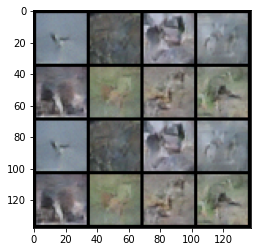

5
26.111626
x_i shape
torch.Size([8, 3, 32, 32])


In [ ]:
guide(None,0.0)


### Playground

In [ ]:
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
# gpu_usage()   

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  